In [1]:
import numpy as np
import cmath
from scipy import fftpack as fftp
from scipy import stats
import os
import random as rm
from scipy import ndimage
from scipy.io.wavfile import write
from scipy.io.wavfile import read
from scipy import signal
import wave


%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
output_dir = output_dir = os.path.join('.','output')

----------------------
<h1><center> Taller 04 </center></h1>

<h3><div style="text-align: right"> Diego Rodriguez - 201425220 </div></h3>

------------------------
# Ejemplo 1 - Diferenciación

In [3]:
# Setup the problem

L1=20 # define the computational domain [-L/2,L/2]
n1=128 # define the number of Fourier modes 2^n

x2=linspace(-L1/2,L1/2,n1+1); # define the domain discretization
x=x2[0:n1] # consider only the first n points: periodicity

dx=x[1]-x[0] # dx value needed for finite difference
u_1 = 1/np.cosh(x) # function to take a derivative of
k_vect = np.concatenate([np.arange(0,(n1/2-1)+1),np.arange((-n1/2),-1+1)]) # Create a vector to apply to k
k1=(2*np.pi/L1)*k_vect # k rescaled to 2pi domain

ut_1=fftp.fft(u_1) # FFT the function

In [4]:
#  FFT calculation of derivatives

ut1=1j*k1*ut_1 # first derivative
ut2=-k1*k1*ut_1 # second derivative
u1=fftp.ifft(ut1).real # inverse transform
u2=fftp.ifft(ut2).real # inverse transform

u1exact=(-1/np.cosh(x))*tanh(x) # analytic first derivative
u2exact=(1/np.cosh(x))-2*(1/np.cosh(x))**3 # analytic second derivative

In [5]:
# Calcular la derivada usando np.gradient - usa diferencias finitas con precisión de orden 2

ux1=np.gradient(u_1,dx)
ux2=np.gradient(ux1,dx)

In [6]:
# Función para calcular el error RMSEN entre las series

def rmsen(old,new):   
    
    n = len(new)
    resta = [] 

    for i in range(n):
        x_old = old[i]
        x_new = new[i]

        x = (x_old - x_new)**2

        resta.append(x)

    error = np.sqrt((1/n)*sum(resta))/(np.max(old) - np.min(old))
        
    print("El error RMSEn es: {0:.5f}%".format(error*100))

    return error  

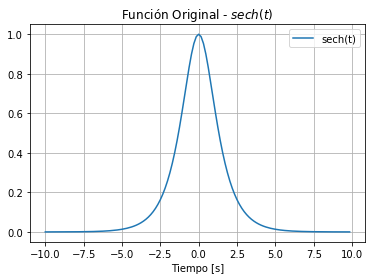

In [7]:
pylab.plot(x,u_1,label='sech(t)')
pylab.title('Función Original - $sech(t)$')
pylab.xlabel('Tiempo [s]')
pylab.grid()
pylab.legend(loc='best')

#pylab.savefig(os.path.join(output_dir,'Ejemplo1-Func_Or.png'), dpi=600)

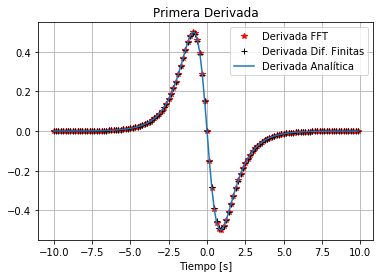

In [8]:
pylab.plot(x,u1,'r*',label='Derivada FFT')
pylab.plot(x,ux1,'k+',label='Derivada Dif. Finitas')
pylab.plot(x,u1exact,label='Derivada Analítica')
pylab.title('Primera Derivada')
pylab.xlabel('Tiempo [s]')
pylab.grid()
pylab.legend(loc='best')

#pylab.savefig(os.path.join(output_dir,'Ejemplo1-First_Der.png'), dpi=600)

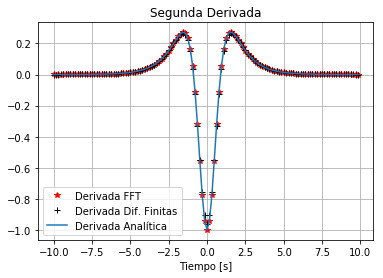

In [9]:
pylab.plot(x,u2,'r*',label='Derivada FFT')
pylab.plot(x,ux2,'k+',label='Derivada Dif. Finitas')
pylab.plot(x,u2exact,label='Derivada Analítica')
pylab.title('Segunda Derivada')
pylab.xlabel('Tiempo [s]')
pylab.grid()
pylab.legend(loc='best')

#pylab.savefig(os.path.join(output_dir,'Ejemplo1-Second_Der.png'), dpi=600)

In [10]:
# Calcular Errores
print('Primera Derivada')
rmsen_exact1 = rmsen(u1exact,u1exact)
rmsen_fft1 = rmsen(u1exact,u1)
rmesn_dif1 = rmsen(u1exact,ux1)
print('\n')

print('Segunda Derivada')
rmsen_exact2 = rmsen(u2exact,u2exact)
rmsen_fft2 = rmsen(u2exact,u2)
rmesn_dif2 = rmsen(u2exact,ux2)

Primera Derivada
El error RMSEn es: 0.00000%
El error RMSEn es: 0.00101%
El error RMSEn es: 0.15572%


Segunda Derivada
El error RMSEn es: 0.00000%
El error RMSEn es: 0.01167%
El error RMSEn es: 0.57166%


# Análisis

|![Ejemplo1-Func_Or.png](files/output/Ejemplo1-Func_Or.png)|![Ejemplo1-First_Der.png](files/output/Ejemplo1-First_Der.png)|![Ejemplo1-Second_Der.png](files/output/Ejemplo1-Second_Der.png)|
|:-------------------------------------:|:------------------------------------:|:-------------------------------------:|
|Figura 1a. Señal original a ser derivada con Fourier y diferencias finitas. |Fig 1b. Primera derivada de la señal original. Derivada de manera exacta, con Fourier, y con diferencias finitas. |Fig 1c. Segunda derivada de la señal original. Derivada de manera exacta, con Fourier, y con diferencias finitas.|

<h5><center>Tabla 1. Errores para los diferentes tipos de diferenciación para la primera derivada de la señal </center></h5>

|Tipo de Diferenciacón|Error RMSEN%|
|-------:|:----:|
|Exacta | 0 |
|Fourier (FFT) | 0.00101% |
|Diferencias Finitas | 0.15572% |

A pesar de que las magnitudes de los errores son pequeñas, el error de diferencias finitas para la primera deivada es 197% más grande que el error utilizando la transformada de Fourier. 

<h5><center>Tabla 2. Errores para los diferentes tipos de diferenciación para la segunda derivada de la señal </center></h5>

|Tipo de Diferenciacón|Error RMSEN%|
|-------:|:----:|
|Exacta | 0 |
|Fourier (FFT) | 0.01167% |
|Diferencias Finitas | 0.57166% |

Al igual que en la Tabla 1, se ve que para la segunda derivada la transformada de Fourier tiene un error mucho más pequeño. En este caso el error por diferencias finitas es 192% más gande que el error po Fourier.


----------------------------
# Constantes - Ejemplos Filtros

In [11]:
L=30 # time slot to transform
n=512 # number of Fourier modes 2^9
t2=linspace(-L,L,n+1) 
t=t2[0:n] # time discretization

k_vect2 = np.concatenate([np.arange(0,(n/2-1)+1),np.arange((-n/2),-1+1)]) # Create a vector to apply to k
k=(2*np.pi/(2*L))*k_vect2 # frequency components of FFT
ks = fftp.fftshift(k) #Apply shift to k

u=1/np.cosh(t) # ideal signal in the time domain
ut = fftp.fft(u) # FFT the function

noise = 10 # noise level

-----------------------
# Ejemplo 2 - Filtrado Simple

In [12]:
wn_2 = np.random.normal(0,1,n) # white noise
unt_2 = ut + noise*(wn_2+1j*wn_2) # add noise
un_2 = fftp.ifft(unt_2) # return to time domain

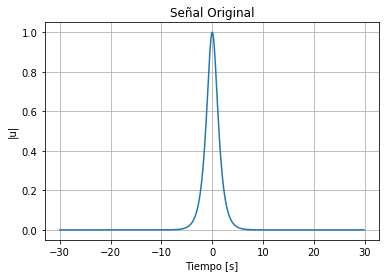

In [13]:
pylab.plot(t,u)
pylab.title('Señal Original')
pylab.xlabel('Tiempo [s]')
pylab.ylabel('|u|')
pylab.grid()
pylab.legend(loc='best')

#pylab.savefig(os.path.join(output_dir,'Ejemplo2-Sign_Or.png'), dpi=600)

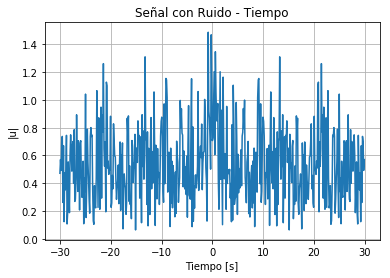

In [14]:
pylab.plot(t,np.abs(un_2))
pylab.title('Señal con Ruido - Tiempo')
pylab.xlabel('Tiempo [s]')
pylab.ylabel('|u|')
pylab.grid()
pylab.legend(loc='best')

#pylab.savefig(os.path.join(output_dir,'Ejemplo2-Sign_Noise_Time.png'), dpi=600)

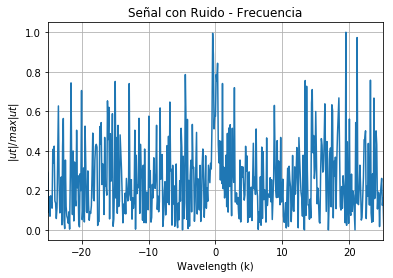

In [15]:
pylab.plot(ks,(np.abs(fftp.fftshift(unt_2))/np.max(np.abs(fftp.fftshift(unt_2)))))
pylab.title('Señal con Ruido - Frecuencia')
pylab.xlabel('Wavelength (k)')
pylab.ylabel('$|ut|/max|ut|$')
pylab.xlim([-25,25])
pylab.grid()
pylab.legend(loc='best')

#pylab.savefig(os.path.join(output_dir,'Ejemplo2-Sign_Noise_Freq.png'), dpi=600)

In [16]:
unfk = exp(-0.2*((k)**2))*unt_2 # Aplicar filtro en dominio freq
unft = fftp.ifft(unfk) # Devolverse a dominio tiempo

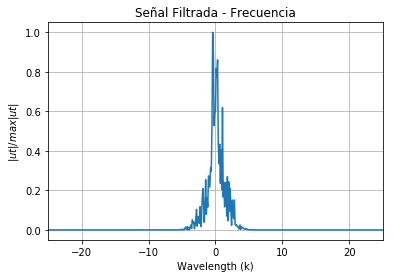

In [17]:
pylab.plot(ks,(np.abs(fftp.fftshift(unfk))/np.max(np.abs(fftp.fftshift(unfk)))))
pylab.title('Señal Filtrada - Frecuencia')
pylab.xlabel('Wavelength (k)')
pylab.ylabel('$|ut|/max|ut|$')
pylab.xlim([-25,25])
pylab.grid()
pylab.legend(loc='best')

#pylab.savefig(os.path.join(output_dir,'Ejemplo2-Sign_Filtered_Freq_15.png'), dpi=600)

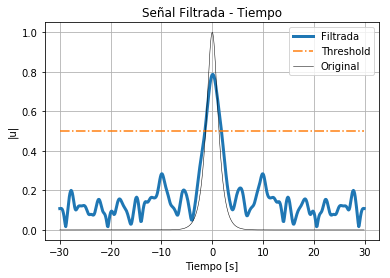

In [18]:
pylab.plot(t,np.abs(unft),linewidth=3.0, label='Filtrada')
pylab.plot(t,linspace(0.5,0.5,len(t)), '-.', label='Threshold')
pylab.plot(t,u,'k',linewidth=0.5, label='Original')
pylab.title('Señal Filtrada - Tiempo')
pylab.xlabel('Tiempo [s]')
pylab.ylabel('|u|')
pylab.grid()
pylab.legend(loc='best')

#pylab.savefig(os.path.join(output_dir,'Ejemplo2-Sign_Filtered_Time_15.png'), dpi=600)

# Análisis

|![Ejemplo2-Sign_Or.png](files/output/Ejemplo2-Sign_Or.png)|![Ejemplo2-Sign_Noise_Time.png](files/output/Ejemplo2-Sign_Noise_Time.png)|![Ejemplo2-Sign_Noise_Freq.png](files/output/Ejemplo2-Sign_Noise_Freq.png)|
|:-------------------------------------:|:------------------------------------:|:-------------------------------------:|
|Figura 2a. Señal original a la cual se le va agregar ruido y despés intentar limpiar. |Fig 2b. La señal original en dominio de tiempo después de agregarle ruido blanco. |Fig 2c. La señal original en dominio de frecuencia después de agregarle ruido blanco.|

En la Figura 2a se tiene la señal original que fue generada para el ejemplo. En la Figura 2b se tiene la señal con ruido en el dominio de tiempo, y en la Figura 2c se tiene la señal con ruido en el dominio de la frecuencia. 

Para agregarle ruido a la señal se hace una transformada rápida de fourier de la señal original, y estando en el dominio de frecuencia se genera una segunda señal con media 0 y desviacón estándar 1 de la misma longitud que la señal original. Se suman estas dos señales para tener la nueva señal con ruido, y se hace una transformada de fourier inversa para regresar al dominio de tiempo y simular tener una señal ruidosa. 

Después se aplica un flitro de Gauss según 

<h2><center> $F(k) = e^{-\tau (k-k_0)^2}$ </center></h2>

En donde:
* $\tau$ es el ancho de banda del filtro. 
* $k_0$ es la frecuencia central de la señal
* $k$ son las frecuencias que tiene la señal

Entre más lejos esté $k$ de $k_0$, más se atenuará la señal. Para este case $k_0 = 0$

Después de aplicar el filtro en el dominio de frecuencia se obtienen las siguientes gráficas: 

|![Ejemplo2-Sign_Filtered_Freq.png](files/output/Ejemplo2-Sign_Filtered_Freq.png)|![Ejemplo2-Sign_Filtered_Time.png](files/output/Ejemplo2-Sign_Filtered_Time.png)|
|:-------------------------------------:|:------------------------------------:|
|Figura 3a. Señal filtrada en el dominio de frecuencia utilizando un $k_0 = 0$. |Fig 3b. Señal filtrada en el dominio de frecuencia utilizando un $k_0 = 0$. |

Se puede ver que el filtro atenua las frecuencias lejos de $k_0$ de manera bastante eficiente. En la Figura 3b se puede ver la señal después de ser filtrada y en el dominio del tiempo. Se incluye la señal original para poder compararlas y se agregó un límite horizontal en 0.5. Esto sería equivalente a un límite de detección por un radar, es decir sólo lo que esté por encima sería considerado. Cuando se filtra la señal, el ruido queda por debajo de este límite y la señal original es detectada. 

A manera de ejemplo se aplicó un filtro alrededo de un $k_0$ que no corresponde a la señal original y se puede ver en las siguientes figuras. 

|![Ejemplo2-Sign_Filtered_Freq_15.png](files/output/Ejemplo2-Sign_Filtered_Freq_15.png)|![Ejemplo2-Sign_Filtered_Time_15.png](files/output/Ejemplo2-Sign_Filtered_Time_15.png)|
|:-------------------------------------:|:------------------------------------:|
|Figura 3a. Señal filtrada en el dominio de frecuencia utilizando un $k_0 = 15$. |Fig 3b. Señal filtrada en el dominio de frecuencia utilizando un $k_0 = 15$. |

Se puede ver que al escoger un $k_0$ diferente, que no corresponde a la frecuencia central de la señal, a pesar de que en el dominio de frecuencia exista un pico en esa frecuencia escogida, en el dominio de tiempo no se detectaría nada por el radar pues la frecuencia que se esperaba no coincide con la frecuencia de la señal. 

----------------------
# Ejemplo 3 - Promediar Señales

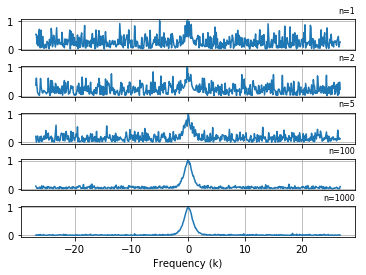

In [19]:
realize = [1,2,5,100,1000]

signals = []

f, axarr = plt.subplots(len(realize), sharex=True)
f.subplots_adjust(hspace=0.5)

for ii in range(len(realize)):
    
    ave = np.zeros(n)
    
    for i in range(realize[ii]):
    
        wn = np.random.normal(0,1,n) # white noise
        utn = ut + noise*(wn+1j*wn) # add noise
        
        ave = ave + utn
        
    ave = ave/realize[ii]
    
    dat = (np.abs(fftp.fftshift(ave))/np.max(np.abs(fftp.fftshift(ave))))
    
    signals.append(dat)
    
    axarr[ii].plot(ks, dat)
    axarr[ii].set_title('n={}'.format(realize[ii]), 
                        loc='right',
                        fontsize = 8)
    axarr[ii].grid()
    axarr[len(realize)-1].set_xlabel('Frequency (k)')
    

#pylab.savefig(os.path.join(output_dir,'Averaging.png'), dpi=600)

# Análisis

|![Averaging.png](files/output/Averaging.png)|
|:-------------------------------------:|
|Figura 4. Se ven diferentes señales cada una con un número de iteraciones diferentes (identificado por * n= * en la parte superior derecha). Entre más señales se haya utilizado para promediar, más limpia va a ser la señal obtenida. Como todas tienen ruido blanco, y este tiene como característica principal una media de 0, cuando se promedian el ruido se promedia a cero y la señal original queda limpia. |

-------------------
# Ejemplo 4 - Análisis de Audio

#### Función para generar una señal de audio

In [20]:
# tone synthesis
def note(freq, len, amp=1, rate=44100):
    t_n = np.linspace(0,len,len*rate)
    data = np.sin(2*np.pi*freq*t_n)*amp
    return data.astype(np.int16) # two byte integers

#### Función par analizar una señal de audio [2]

In [21]:
def sound_analysis(data, fs, fft_size, overlap_fac):
    #data - a numpy array containing the signal to be processed
    #fs - a scalar which is the sampling frequency of the data
    #fft_size - size of the window (1/2 of fs is good)
    #overlap_fac - how much do windows overlap (0.5 is good)

    hop_size = np.int32(np.floor(fft_size * (1-overlap_fac)))
    pad_end_size = fft_size          # the last segment can overlap the end of the data array by no more than one window size
    total_segments = np.int32(np.ceil(len(data) / np.float32(hop_size)))
    t_max = len(data) / np.float32(fs)

    window = np.hanning(fft_size)  # our half cosine window
    inner_pad = np.zeros(fft_size) # the zeros which will be used to double each segment size

    proc = np.concatenate((data, np.zeros(pad_end_size)))              # the data to process
    result = np.empty((total_segments, fft_size), dtype=np.float32)    # space to hold the result

    for i in range(total_segments):                       # for each segment
        current_hop = hop_size * i                        # figure out the current segment offset
        segment = proc[current_hop:current_hop+fft_size]  # get the current segment
        windowed = segment * window                       # multiply by the half cosine function
        padded = np.append(windowed, inner_pad)           # add 0s to double the length of the data
        spectrum = np.fft.fft(padded) / fft_size          # take the Fourier Transform and scale by the number of samples
        autopower = np.abs(spectrum * np.conj(spectrum))  # find the autopower spectrum
        result[i, :] = autopower[:fft_size]               # append to the results array

    result = 20*np.log10(result)          # scale to db
    result = np.clip(result, -20, 200)    # clip values
    
    return result

In [22]:
# C, E, G notes, 2 seconds, 44100 samples per second
tone_C = note(523,2,amp=10000)
tone_E = note(622,2,amp=10000)
tone_G = note(784,2,amp=10000)

# Add notes to create a tune
tune1 = np.concatenate([tone_C,tone_E])
tune2 = np.concatenate([tune1,tone_G])
tone = np.concatenate([tune2,tone_C])

write('Tunes.wav',44100,tone) # writing the sound to a file

In [23]:
result1 = sound_analysis(tone, 44100, 22050, 0.5)

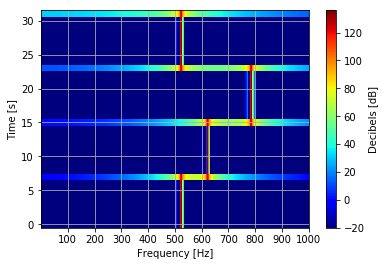

In [25]:
img = plt.imshow(result1, origin='lower', cmap='jet', interpolation='nearest', aspect='auto')
plt.xlabel('Frequency [Hz]')
plt.xlim([0,1000])
plt.xticks([100,200,300,400,500,600,700,800,900,1000])
plt.ylabel('Time [s]')
plt.grid()
cbar = plt.colorbar()
cbar.set_label('Decibels [dB]')

#pylab.savefig(os.path.join(output_dir,'Ejemplo4-1.png'), dpi=600)

In [26]:
# Ahora vamos a importar una señal de audio 
signal = read('HBD_mono_noise.wav')
sig_array = np.array(signal[1],dtype=float)

Text(0.5,1,'Audio Original')

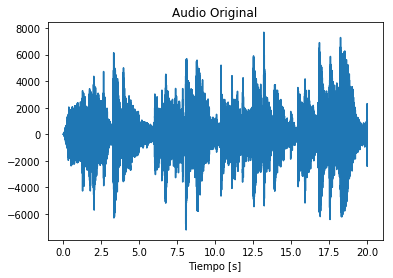

In [27]:
tn = linspace(0,20,len(sig_array))

pylab.plot(tn,sig_array)
pylab.xlabel('Tiempo [s]')
pylab.title('Audio Original')

#pylab.savefig(os.path.join(output_dir,'Ejemplo4-2-Audio_Original.png'), dpi=600)

In [29]:
result2 = sound_analysis(sig_array, 48000, 24000, 0.5)

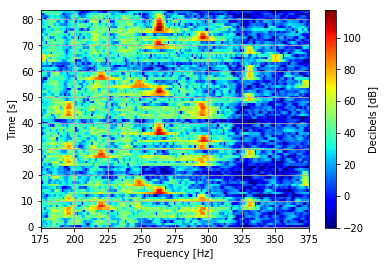

In [30]:
img = plt.imshow(result2, origin='lower', cmap='jet', interpolation='nearest', aspect='auto')
plt.xlabel('Frequency [Hz]')
plt.xlim([175,375])
#plt.xticks([100,150,200,250,300,350,400])
plt.ylabel('Time [s]')
plt.grid()
cbar = plt.colorbar()
cbar.set_label('Decibels [dB]')

#pylab.savefig(os.path.join(output_dir,'Ejemplo4-2.png'), dpi=600)

In [31]:
W = np.fft.fftfreq(sig_array.size,20/sig_array.size)

In [32]:
sig_fft = np.fft.fft(sig_array)

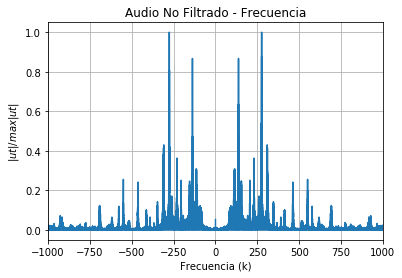

In [33]:
pylab.plot(W,np.abs(sig_fft)/np.max(np.abs(sig_fft)))
pylab.title('Audio No Filtrado - Frecuencia')
pylab.xlabel('Frecuencia (k)')
pylab.ylabel('$|ut|/max|ut|$')
pylab.xlim([-1000,1000])
pylab.grid()
pylab.legend(loc='best')

#pylab.savefig(os.path.join(output_dir,'Ejemplo4-2-Audio_Freq.png'), dpi=600)

In [34]:
# Aplicar un filtro manual
sig_filtro = np.fft.fft(sig_array)

for i in range(len(W)):
    if W[i] >= 195:     # Es mayor que 195 Hz?
        if W[i] <= 370: # Es menor a 370 Hz? 
            if (np.abs(sig_fft[i])/np.max(np.abs(sig_fft))) >= 0.075:  # La magnitud es mayor a 0.075?
                sig_filtro[i] = sig_fft[i] # Si cumple todo mantener el valor
            elif W[i] >= 348:    # Las notas más altas tienen ua magitud pequeña
                sig_filtro[i] = sig_fft[i]
            else: 
                sig_filtro[i] = 0
        else:
            sig_filtro[i] = 0
    else: 
        sig_filtro[i] = 0
        
sig_new = fftp.ifft(sig_filtro) # Devolverse a dominio tiempo

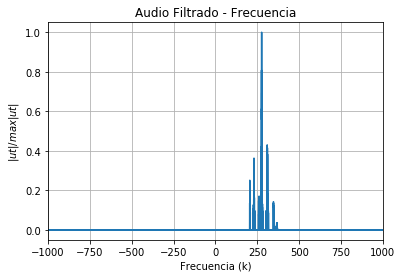

In [35]:
# Graficar el audio filtrado
pylab.plot(W,np.abs(sig_filtro)/np.max(np.abs(sig_filtro)))
pylab.title('Audio Filtrado - Frecuencia')
pylab.xlabel('Frecuencia (k)')
pylab.ylabel('$|ut|/max|ut|$')
pylab.xlim([-1000,1000])
pylab.grid()
pylab.legend(loc='best')

#pylab.savefig(os.path.join(output_dir,'Ejemplo4-2-Audio_Freq_Filtro.png'), dpi=600)

C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


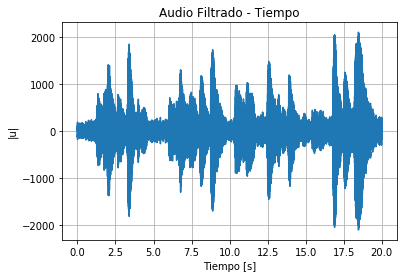

In [36]:
# Graficar el audio filtrado
pylab.plot(tn,sig_new)
pylab.title('Audio Filtrado - Tiempo')
pylab.xlabel('Tiempo [s]')
pylab.ylabel('|u|')
pylab.grid()
pylab.legend(loc='best')

#pylab.savefig(os.path.join(output_dir,'Ejemplo4-2-Audio_Filtro.png'), dpi=600)

In [37]:
result3 = sound_analysis(sig_new, 48000, 24000, 0.5)

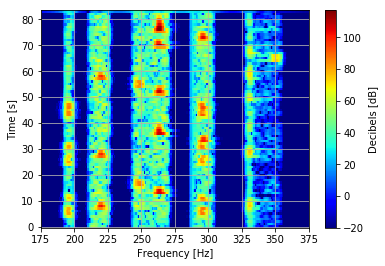

In [38]:
# Sacar espectro de audio filtrado
img = plt.imshow(result3, origin='lower', cmap='jet', interpolation='nearest', aspect='auto')
plt.xlabel('Frequency [Hz]')
plt.xlim([175,375])
#plt.xticks([100,150,200,250,300,350,400])
plt.ylabel('Time [s]')
plt.grid()
cbar = plt.colorbar()
cbar.set_label('Decibels [dB]')

#pylab.savefig(os.path.join(output_dir,'Ejemplo4-2-New.png'), dpi=600)

# Análisis

|![Ejemplo4-1.png](files/output/Ejemplo4-1.png)|
|:-------------------------------------:|
|Figura 5. Se puede ver muy puntualmente cuales fueron las frecuencias generadas y en qué orden se generaron. Como esta es una señal generada por el computador, no tiene ruido y por eso es muy fácil ver las frecuencias. En esta señal se generó un tono de Do con 523Hz, un tono de Mi con 622Hz, y un tono de Sol con 784Hz. El órden de la señal fue Do-Mi-Sol-Do, lo cual se identifica muy fácilmente en esta figura. |


|![Ejemplo4-2-Audio_Original.png](files/output/Ejemplo4-2-Audio_Original.png)|![Ejemplo4-2-Audio_Freq.png](files/output/Ejemplo4-2-Audio_Freq.png)|
|:-------------------------------------:|:------------------------------------:|
|Figura 6a. Audio original en formato .wav que se va a intentar analizar y filtrar. |Fig 6b. Audio original en dominio de frecuencia, revela una concentración alrededor de k = 700 |

Después de obtener la señal de audio, se aplicó la función que permite identificar las frecuencias más predominantes y el orden en el que ocurrieron, como se puede ver en la siguiente figura. 

|![Ejemplo4-2.png](files/output/Ejemplo4-2.png)|
|:-------------------------------------:|
|Figura 7. En el espectro de esta figura se puede ver claramente que hubo unas frecuencias más predominantes que otras, y más o menos se puede identificar el orden en el que se tocaron las notas. De grave a agudo las notas son: Sol, La, Si, Do, Re, Mi, y Fa.|

El siguiente paso fue intentar aplicar un filtro, sin embargo esto se hizo de manera empírica (prueba y error) y no resultó en mejoras significativas. 

<h2><center> $F(k) = e^{-\tau (k-k_0)^2}$ </center></h2>

En donde:
* $\tau$ = 0.00001 
* $k_0$ = 700

|![Ejemplo4-2-Audio_Freq_Filtro.png](files/output/Ejemplo4-2-Audio_Freq_Filtro.png)|![Ejemplo4-2-Audio_Filtro.png](files/output/Ejemplo4-2-Audio_Filtro.png)|
|:-------------------------------------:|:------------------------------------:|
|Figura 8a. Audio en dominio de frecuencia después de aplicar el filtro. |Fig 8b. Audio después de aplicar el filtro y aplicar una transformada de Fourier inversa. |

|![Ejemplo4-2_Final.png](files/output/Ejemplo4-2_Final.png)|
|:-------------------------------------:|
|Figura 9. Aquí se presenta el espectro de frecuencias en el tiempo para el audio filtrado. Si se compara con la Figura 5, se ve que es extremadamente parecido y el filtro no hizo gran cosa. Sin embargo, es interesante ver que mediante esta metolodgía de obtener el espectro, se pueden identificar muy claramente las notas que se tocaron en la melodía grabada. En este caso se grabó un pedazo de la canción *Feliz Cumpleaños*. |

---------
# Referencias

[1] 	Kutz, "Computational Methods for Data Analysis". 

[2] 	K. NJ, Kevin's Projects, 2014. 
